In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string

import matplotlib
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from pymongo import MongoClient
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    plot_roc_curve,
    precision_score,
    recall_score,
)
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
sns.set_theme()

In [2]:
#data = pd.read_json('Movies_and_TV_5.json', lines=True)

In [3]:

from pymongo import MongoClient

client = MongoClient('localhost', 27017)
db = client['amazon_reviews']
reviews = db['reviews']
reviews_cleaned = db['reviews_cleaned']

In [16]:
#for row_num in range(data.shape[0]):
#    row = (data.iloc[row_num])
#    reviews.insert_one({'reviewerID': str(row['reviewerID']), 'asin':str(row['asin']), 'reviewerName':row['reviewerName'], 'reviewText': row['reviewText'], 'helpful':row['helpful'], 'overall':str(row['overall']), 'summary':row['summary'], 'unixReviewTime':str(row['unixReviewTime']), 'reviewTime':row['reviewTime']})

In [4]:
original_df = pd.DataFrame(reviews_cleaned.find({}, {'stemmed':0}))

In [5]:
df = original_df

In [6]:
df['review_char_length'] = df['reviewText'].apply(len)
df['stars'] = df['overall'].apply(lambda x: int(x))
df = df[(df['review_char_length']>500) & (df['review_char_length'] < 3000)]

In [50]:
#df['reviewerName'].value_counts()

Amazon Customer                          3508
Michael Butts                            2156
Tsuyoshi                                 2121
Grady Harp                               1911
Hiram Gomez Pardo                        1887
                                         ... 
Evigan "d-(O.o)-b"                          1
Jonquil                                     1
Gregory L Leber                             1
Scottiboy "I've seen a movie or two"        1
Amazon Customer "Baghdad Cinemaphile"       1
Name: reviewerName, Length: 67273, dtype: int64

In [7]:
one_star_reviews = df[df['stars'] == 1]
two_star_reviews = df[df['stars'] == 2]
three_star_reviews = df[df['stars'] == 3]
four_star_reviews =df[df['stars'] == 4]
five_star_reviews = df[df['stars'] == 5]

<BarContainer object of 5 artists>

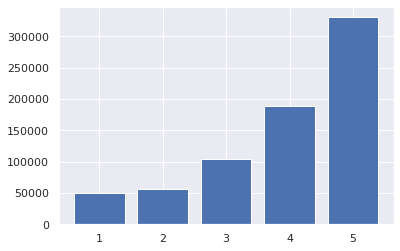

In [17]:
fig, ax = plt.subplots()
ax.bar(df['stars'].value_counts().index,df['overall'].value_counts())

In [9]:
balanced_10k_each = pd.concat([one_star_reviews.iloc[:10000], two_star_reviews.iloc[:10000], three_star_reviews.iloc[:10000], four_star_reviews.iloc[:10000], five_star_reviews.iloc[:10000]])
balanced_40k_each = pd.concat([one_star_reviews.iloc[:40000], two_star_reviews.iloc[:40000], three_star_reviews.iloc[:40000], four_star_reviews.iloc[:40000], five_star_reviews.iloc[:40000]])
balanced_40k_each['stars'].value_counts()

5    40000
4    40000
3    40000
2    40000
1    40000
Name: stars, dtype: int64

In [11]:
import nltk
nltk_stopwords = nltk.corpus.stopwords.words('english')
tokenizer = nltk.RegexpTokenizer(r"\w+")

stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def NLP_cleaner_mongodb(pandas_df, collection, document_column_name = 'reviewText'):
    '''
    takes pandas dataframe and inserts entries into mongodb collection with lemmatized text
    '''
    '''
    df = pandas_df
    df['unicode'] = df[document_column_name].str.encode('ascii', 'ignore').str.decode('ascii')
    df['lower'] = df['unicode'].apply(lambda x: x.lower())
    df['remove_punct'] = df['lower'].apply(lambda x: tokenizer.tokenize(x))
    df['no_stopwords'] = df['remove_punct'].apply(lambda x: remove_stopwords(x))
    df['lemmatized'] = df['no_stopwords'].apply(lambda x: lemmatize_text(tokenize(x)))
    '''
    for row_num in range(pandas_df.shape[0]):
        row = (pandas_df.iloc[row_num])
        unicode = row[document_column_name].encode('ascii', 'ignore').decode('ascii')
        lower = unicode.lower()
        remove_punct = tokenize(lower)
        no_stopwords = remove_stopwords(remove_punct)
        lemmatized = lemmatize_text(tokenize(no_stopwords))
        stemmed = stem_text(tokenize(no_stopwords))
        collection.insert_one({'reviewerID': str(row['reviewerID']), 'asin':str(row['asin']), 'reviewerName':row['reviewerName'], 'reviewText': row['reviewText'], 'helpful':row['helpful'], 'overall':str(row['overall']), 'summary':row['summary'], 'unixReviewTime':str(row['unixReviewTime']), 'reviewTime':row['reviewTime'], 'lemmatized':lemmatized, 'stemmed':stemmed})
    
    
    


In [115]:
#NLP_cleaner_mongodb(df, reviews_cleaned)

In [12]:


def remove_punctuation(comment):
    no_punct = [word for word in comment if word not in string.punctuation]
    return ' '.join(no_punct)

def tokenize(comment):
    token = [word.lower() for word in tokenizer.tokenize(comment)]
    return token

def remove_stopwords(comment):
    no_stops_words = [word for word in comment if word not in nltk_stopwords]
    return ' '.join(no_stops_words)

def stem_text(comment):
    stem = [stemmer.stem(word) for word in comment]
    after_stem = ' '.join(stem)
    return after_stem

def lemmatize_text(comment):
    lemma = [lemmatizer.lemmatize(word) for word in comment]
    after_lemma = ' '.join(lemma)
    return after_lemma


In [22]:
multiNB(balanced_40k_each, 'lemmatized', max_features=20000,max_iter=10000)

((0.50855,
  array([0.54003813, 0.44029076, 0.42734194, 0.46121372, 0.63624145]),
  array([0.68908892, 0.42079147, 0.32559899, 0.44376745, 0.65828066])),
 array([[5665, 1741,  382,  239,  194],
        [2573, 3392, 1302,  552,  242],
        [1075, 1702, 2582, 1862,  709],
        [ 608,  584, 1358, 3496, 1832],
        [ 569,  285,  418, 1431, 5207]]),
 MultinomialNB())

<AxesSubplot:>

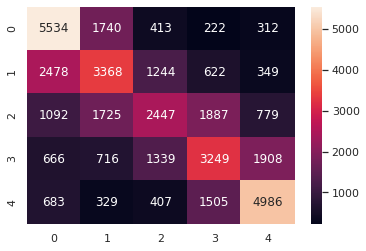

In [37]:
sns.heatmap([[5534, 1740,  413,  222,  312],
        [2478, 3368, 1244,  622,  349],
        [1092, 1725, 2447, 1887,  779],
        [ 666,  716, 1339, 3249, 1908],
        [ 683,  329,  407, 1505, 4986]], annot=True, fmt='g')

In [45]:
tup = rf_test(balanced_10k_each, 'lemmatized', max_depth=15, n_est=400, max_feat = 10000, new_stop_words = ['one', 'two', 'three', 'four', 'five'])
tup

(40000, 10000)


((0.4517, 0.4517, 0.4517),
 array([[1451,  239,   86,   83,  152],
        [ 752,  489,  328,  208,  227],
        [ 336,  280,  516,  453,  383],
        [ 181,  113,  293,  654,  723],
        [ 155,   46,  116,  329, 1407]]),
 RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                        n_estimators=400),
 <40000x10000 sparse matrix of type '<class 'numpy.float64'>'
 	with 3371522 stored elements in Compressed Sparse Row format>)

In [52]:
tdif_most_important_values_for_random_forest(tup[3], tup[2])

AttributeError: get_feature_names not found

<AxesSubplot:>

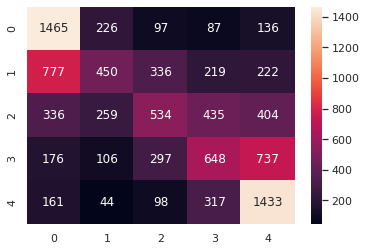

In [28]:
sns.heatmap([[1465,  226,   97,   87,  136],
        [ 777,  450,  336,  219,  222],
        [ 336,  259,  534,  435,  404],
        [ 176,  106,  297,  648,  737],
        [ 161,   44,   98,  317, 1433]], annot=True, fmt='g')

In [17]:
knn_classifier(balanced_10k_each, 'lemmatized')

(0.3619,
 array([[961, 515, 357, 118,  60],
        [707, 643, 396, 189,  69],
        [418, 486, 658, 309,  97],
        [245, 350, 503, 632, 234],
        [164, 211, 372, 581, 725]]))

In [52]:
tup =logreg(balanced_40k_each, 'lemmatized')
tup

((0.511,
  array([0.60002314, 0.46082266, 0.42833653, 0.44747649, 0.58636614]),
  array([0.6515894 , 0.42830283, 0.38851603, 0.42188085, 0.66579276])),
 array([[5186, 1737,  520,  215,  301],
        [2129, 3417, 1537,  527,  368],
        [ 691, 1578, 3126, 1808,  843],
        [ 291,  455, 1633, 3378, 2250],
        [ 346,  228,  482, 1621, 5333]]),
 LogisticRegression(max_iter=2000))

<AxesSubplot:>

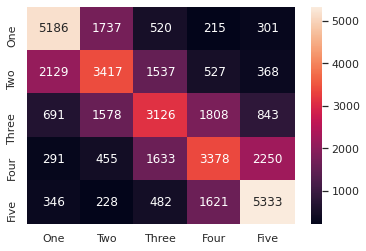

In [48]:
make_heatmap([[5186, 1737,  520,  215,  301],
        [2129, 3417, 1537,  527,  368],
        [ 691, 1578, 3126, 1808,  843],
        [ 291,  455, 1633, 3378, 2250],
        [ 346,  228,  482, 1621, 5333]])

In [7]:
def multiNB(pandas_df, text_column='reviewText', max_features = 1500, max_iter = 2000):

    X = pandas_df[text_column]
    y = pandas_df['overall']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    tvectorizer = CountVectorizer(max_features = max_features, strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b',lowercase=True)
    X_train_tvectorizer = tvectorizer.fit_transform(X_train)
    X_test_tvectorizer = tvectorizer.transform(X_test)


    mnb = MultinomialNB()
    mnb.fit(X_train_tvectorizer, y_train)
    predict = mnb.predict(X_test_tvectorizer)

    a = (accuracy_score(y_test, predict))
    p = (precision_score(y_test, predict, average=None))
    r = (recall_score(y_test, predict, average=None))

    cm = confusion_matrix(y_test, predict)
    
    return (a,p,r), cm, mnb

In [44]:
def rf_test(pandas_df, text_column = 'reviewText', n_est=10, max_depth = 40, max_feat=None, new_stop_words = []):

    X = pandas_df[text_column]
    y = pandas_df['stars']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    
    tvectorizer = TfidfVectorizer(max_features = max_feat, strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b', stop_words=stopwords.words('english')+new_stop_words)
    X_train_tvectorizer = tvectorizer.fit_transform(X_train)
    X_test_tvectorizer = tvectorizer.transform(X_test)
    
    print(X_train_tvectorizer.shape)
    
    rf = RandomForestClassifier(n_estimators = n_est, max_depth = max_depth, class_weight='balanced_subsample')
    rf.fit(X_train_tvectorizer, y_train)
    predict = rf.predict(X_test_tvectorizer)

    a = (accuracy_score(y_test, predict))
    p = (precision_score(y_test, predict, average='micro'))
    r = (recall_score(y_test, predict, average='micro'))

    cm = confusion_matrix(y_test, predict)
    return (a,p,r), cm, rf, X_train_tvectorizer


In [9]:
def knn_classifier(pandas_df, text_column = 'reviewText'):
    
    X = pandas_df[text_column]
    y = pandas_df['stars']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    
    tvectorizer = TfidfVectorizer(token_pattern=r'(?u)\b\w\w+\b', stop_words=stopwords.words('english'))
    X_train_tvectorizer = tvectorizer.fit_transform(X_train)
    X_test_tvectorizer = tvectorizer.transform(X_test)
    
    knn = KNeighborsClassifier(n_neighbors = 2).fit(X_train_tvectorizer, y_train)
    accuracy = knn.score(X_test_tvectorizer, y_test)
    
    knn_predictions = knn.predict(X_test_tvectorizer) 
    cm = confusion_matrix(y_test, knn_predictions)
    
    return accuracy, cm

In [10]:
def logreg(pandas_df, text_column = 'reviewText', max_features=1500, max_iter=2000):

    X = pandas_df[text_column]
    y = pandas_df['stars']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    
    tvectorizer = TfidfVectorizer(max_features = max_features, strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b')
    X_train_tvectorizer = tvectorizer.fit_transform(X_train)
    X_test_tvectorizer = tvectorizer.transform(X_test)

    lr = LogisticRegression(max_iter=max_iter)
    lr.fit(X_train_tvectorizer, y_train)
    predict = lr.predict(X_test_tvectorizer)

    a = (accuracy_score(y_test, predict))
    p = (precision_score(y_test, predict, average=None))
    r = (recall_score(y_test, predict, average=None))
    cm = confusion_matrix(y_test, predict)
    return ((a,p,r),cm,lr)

In [11]:
def make_heatmap(cm):
    categories = ['One', 'Two', 'Three', 'Four', 'Five']
    
    return sns.heatmap(cm, annot=True, fmt='g', xticklabels = categories, yticklabels = categories)

In [12]:
def tdif_most_important_values_for_random_forest(tdif_vectorizer, fit_random_forest):    
    d= {}
    rf = fit_random_forest
    for imp,word in zip(list(rf.feature_importances_),tdif_vectorizer.get_feature_names()):
        d[word] = imp
    sorted_values = list(reversed(sorted(d.values()))) # Sort the values
    sorted_dict = {}
    for i in sorted_values:
        for k in d.keys():
            if d[k] == i:
                sorted_dict[k] = d[k]
                break
    return sorted_dict

In [75]:
#test
tup[3]

TfidfVectorizer(max_features=1000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents='ascii')

In [48]:
dense_matrix = tup[3].todense()

In [51]:
dense_matrix.shape

(40000, 10000)

In [10]:
pandas_df = balanced_10k_each
X = pandas_df['lemmatized']
y = pandas_df['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    
tvectorizer = TfidfVectorizer(max_features = 10000, strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b', stop_words=stopwords.words('english')+['one', 'two', 'three' ,'four', 'five'])
X_train_tvectorizer = tvectorizer.fit_transform(X_train)
X_test_tvectorizer = tvectorizer.transform(X_test)
    
print(X_train_tvectorizer.shape)
    
rf = RandomForestClassifier(n_estimators = 400, max_depth = 20, class_weight='balanced_subsample')
rf.fit(X_train_tvectorizer, y_train)
predict = rf.predict(X_test_tvectorizer)

a = (accuracy_score(y_test, predict))
p = (precision_score(y_test, predict, average='micro'))
r = (recall_score(y_test, predict, average='micro'))

cm = confusion_matrix(y_test, predict)
(a,p,r), cm, rf, X_train_tvectorizer


(40000, 10000)


((0.4626, 0.4626, 0.4626),
 array([[1458,  235,  103,   68,  147],
        [ 763,  515,  318,  210,  198],
        [ 330,  274,  547,  446,  371],
        [ 183,  112,  292,  681,  696],
        [ 151,   56,   91,  330, 1425]]),
 RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                        n_estimators=400),
 <40000x10000 sparse matrix of type '<class 'numpy.float64'>'
 	with 3371522 stored elements in Compressed Sparse Row format>)

In [11]:
dense_matrix = X_train_tvectorizer.todense()

In [15]:
dense_matrix.shape

(40000, 10000)

In [19]:
tvectorizer.get_feature_names()

10000

In [23]:
np.sum(dense_matrix, axis=1).shape

(40000, 1)